# Plot model fits for simulation analysis 3

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pingouin as pg
from psifr import fr

from cymr import cmr
from dcmr import framework
from dcmr import figures
from dcmr import task

res_dir = Path(os.environ['CFR_RESULTS'])
fit_dir = Path(os.environ['CFR_FITS']) / 'merge'
fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim3'

data_file = res_dir / 'cfr_eeg_mixed.csv'
patterns_file = res_dir / 'cfr_patterns.hdf5'
os.makedirs(fig_dir, exist_ok=True)
figures.set_style()

## Read observed and simulated data

In [2]:
patterns = cmr.load_patterns(patterns_file)
rsm = patterns['similarity']['use']

In [3]:
included = ['DCMR-Focused', 'DCMR-Disrupt', 'CMR-MP16-L']
models, model_names = framework.get_sim_models('cfr2', 'set2', included=included)
data = framework.read_model_sims(data_file, fit_dir, models, model_names, block=True)
order = ['DCMR-Focused', 'CMR-MP16-L', 'DCMR-Disrupt', 'Data']

In [4]:
# for speed, omit simulation replications; comment out for final
# data = data.loc[data['list'] <= 48]

## Set colors

In [5]:
curve = sns.color_palette(
    'ch:rot=-.5, light=.6, dark=.3, gamma=1', n_colors=len(models)
)
curve.insert(len(models), (.3, .3, .3))
curve

[(0.44163916703794076, 0.6914342033666265, 0.5414714890673176),
 (0.27424883716016524, 0.5352555384607786, 0.4809527643729599),
 (0.17051215858853222, 0.344636926092434, 0.3959064384004337),
 (0.3, 0.3, 0.3)]

In [6]:
dark = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.6', n_colors=len(models)
)
dark.insert(len(models), (.6, .6, .6))
dark

[(0.725301473503126, 0.8645990769601404, 0.7363315007817791),
 (0.5016677447743987, 0.7426793533080586, 0.6602162691374847),
 (0.33145894574681245, 0.5393097642399239, 0.6005096167923277),
 (0.6, 0.6, 0.6)]

In [7]:
light = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.2', n_colors=len(models)
)
light.insert(len(models), (.85, .85, .85))
light

[(0.8973525746116884, 0.9546730560357413, 0.901891392639006),
 (0.7912737188119296, 0.9119907090651371, 0.870686908851388),
 (0.6820851323976215, 0.8225675908928259, 0.8639314200489312),
 (0.85, 0.85, 0.85)]

In [8]:
opt = {'height': 4, 'aspect': 1, 'palette': curve}

## Conditional response probability by block lag

In [9]:
lag_crp = data.groupby('source').apply(
    task.block_lag_crp, 
    'block', 
    'n_block', 
    test_key='category',
    test=lambda x, y: x == y,
).drop('level_1', axis=1).reset_index()

LINO NOT subset; don't know how to subset; dropped


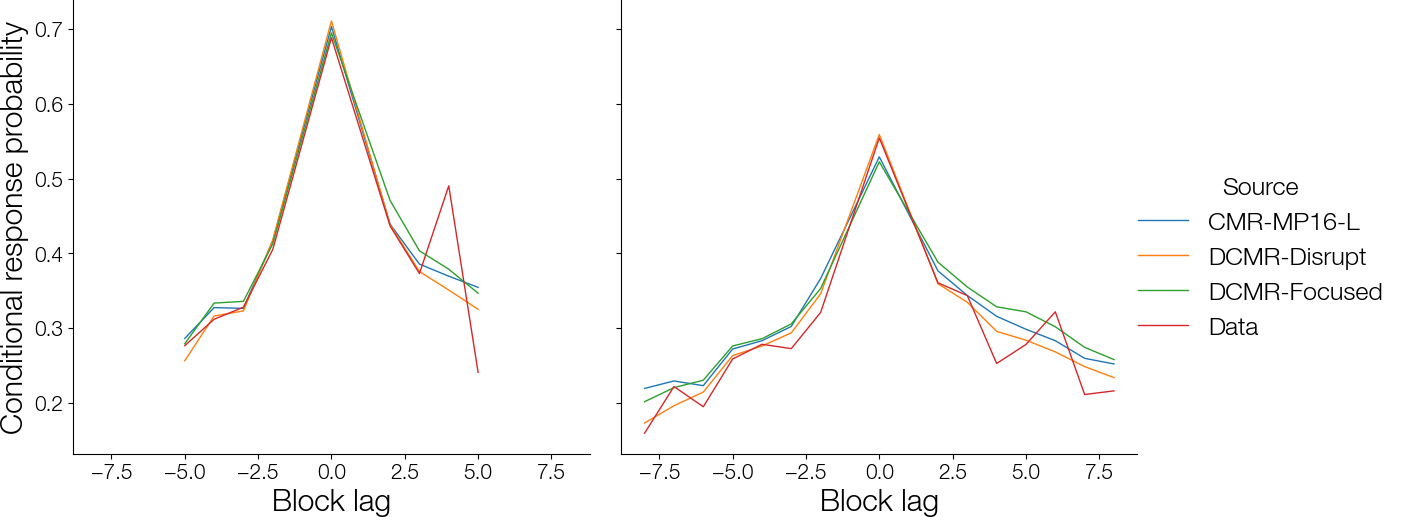

In [10]:
lag_crp['Source'] = lag_crp['source']
g = sns.relplot(
    lag_crp, 
    x='lag',
    y='prob',
    hue='Source', 
    col='n_block', 
    height=6, 
    kind='line',
    errorbar=None,
)
g.set_titles('')
g.set(ylabel='Conditional response probability', xlabel='Block lag');
g.savefig(fig_dir / 'block_crp.pdf')

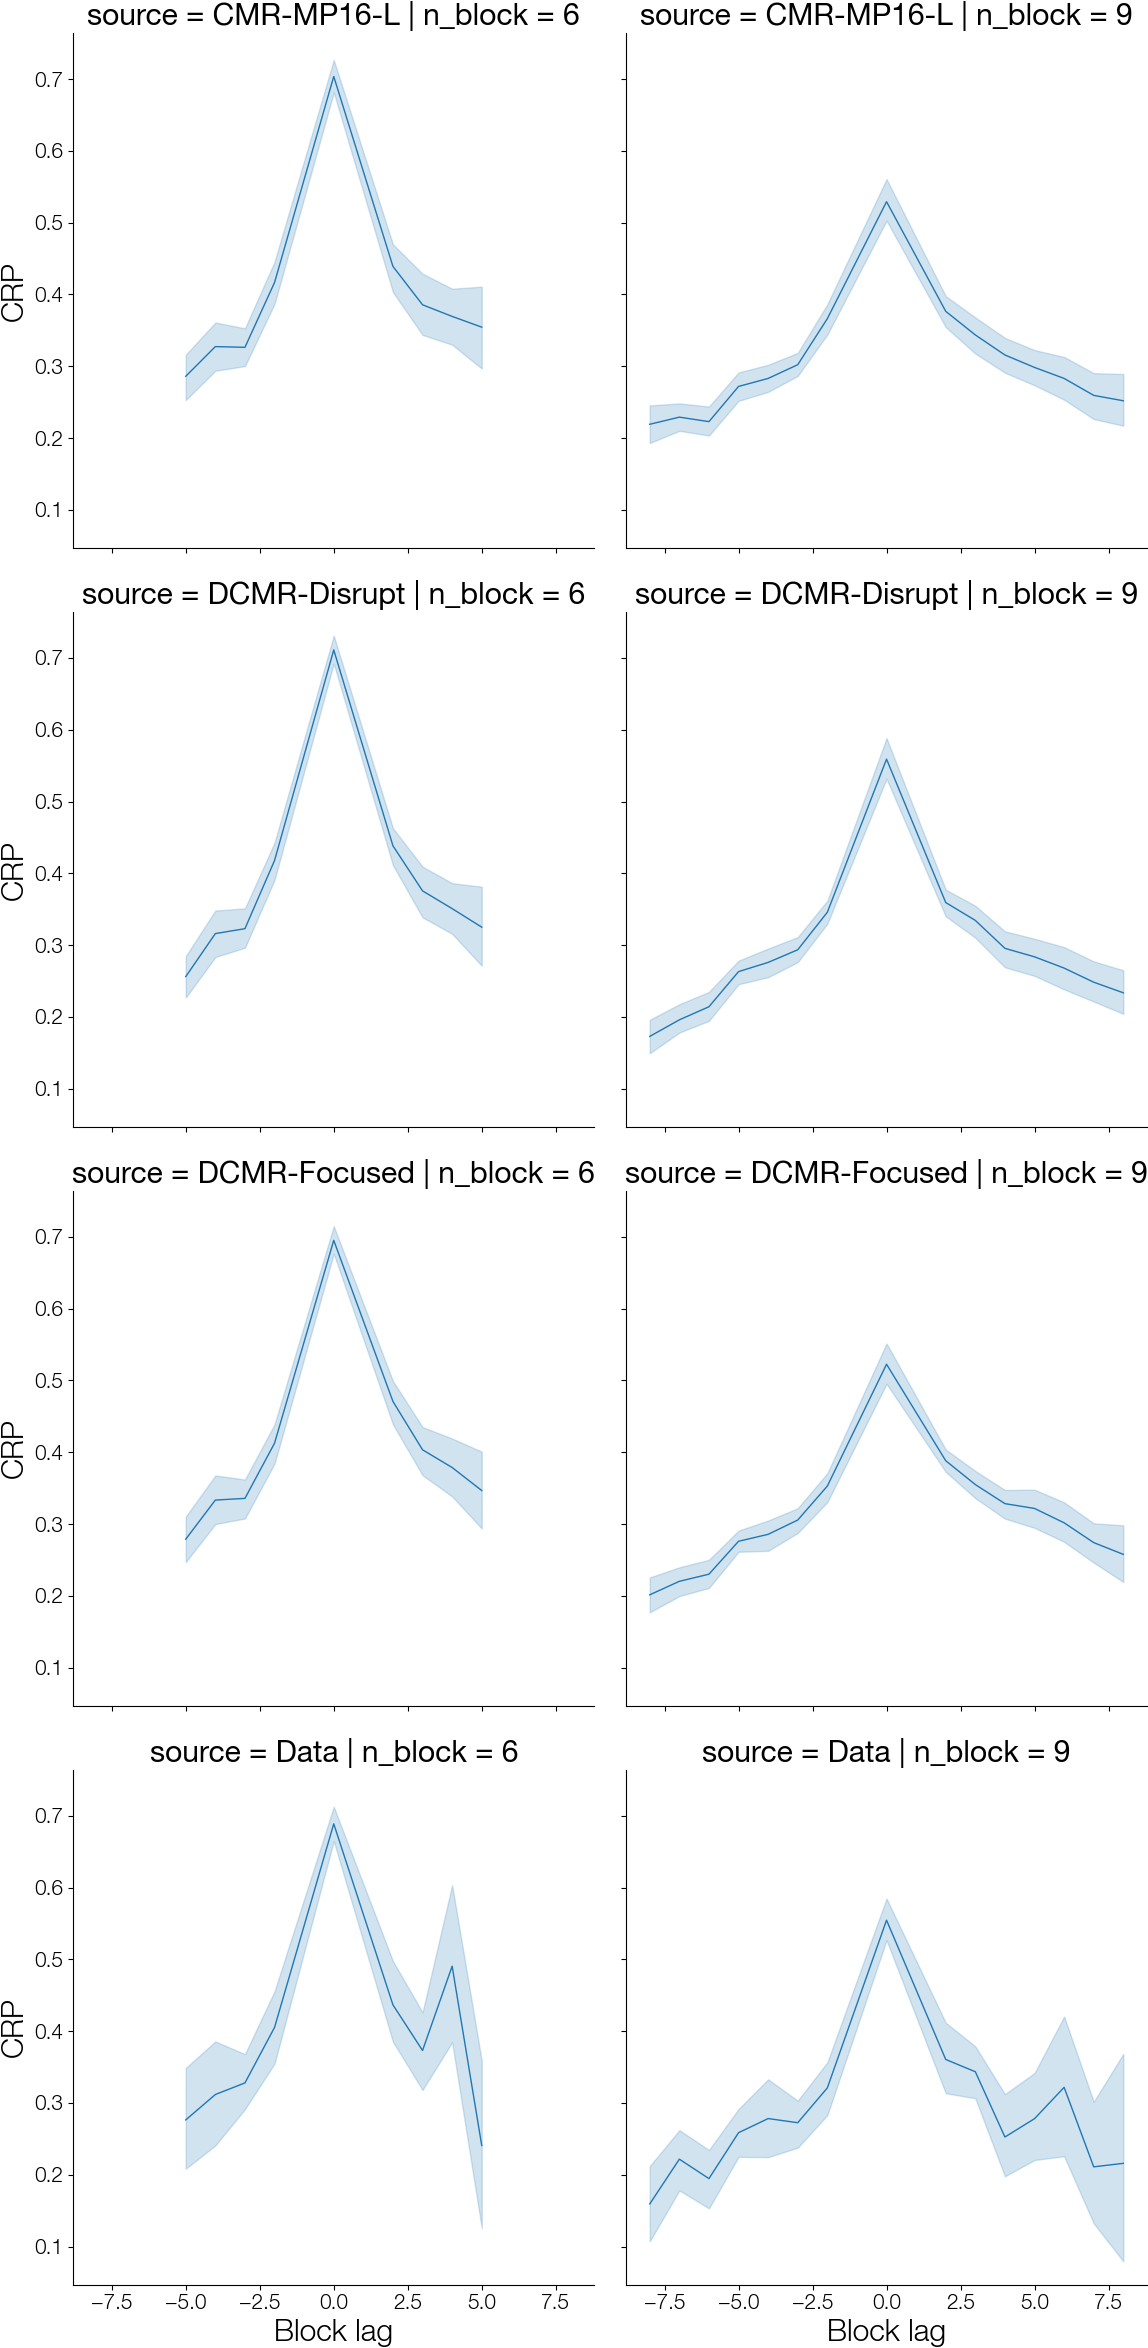

In [11]:
g = sns.relplot(
    lag_crp.reset_index(), 
    x='lag',
    y='prob',
    row='source', 
    col='n_block', 
    height=6, 
    kind='line',
)
g.set(ylabel='CRP', xlabel='Block lag');

## Recall by block

In [12]:
spc = data.groupby('source').apply(task.block_spc, 'block', 'n_block')

LINO NOT subset; don't know how to subset; dropped


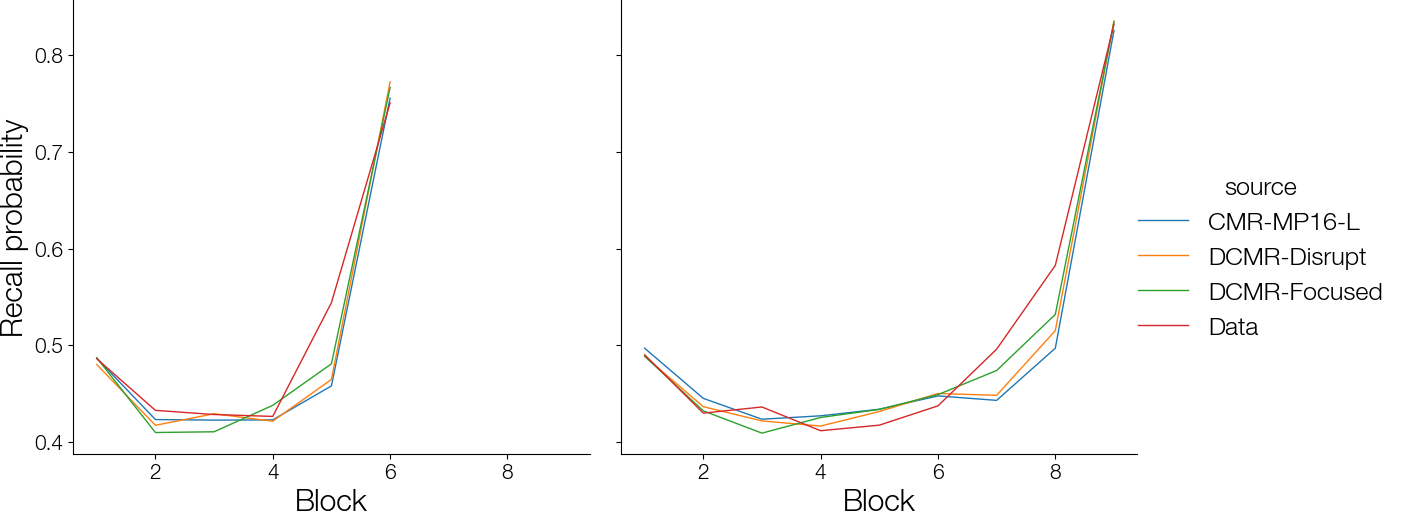

In [13]:
g = sns.relplot(
    spc.reset_index(), 
    x='block',
    y='recall',
    hue='source', 
    col='n_block', 
    height=6, 
    kind='line',
    errorbar=None,
)
g.set_titles('')
g.set(ylabel='Recall probability', xlabel='Block')
g.savefig(fig_dir / 'block_spc.pdf')

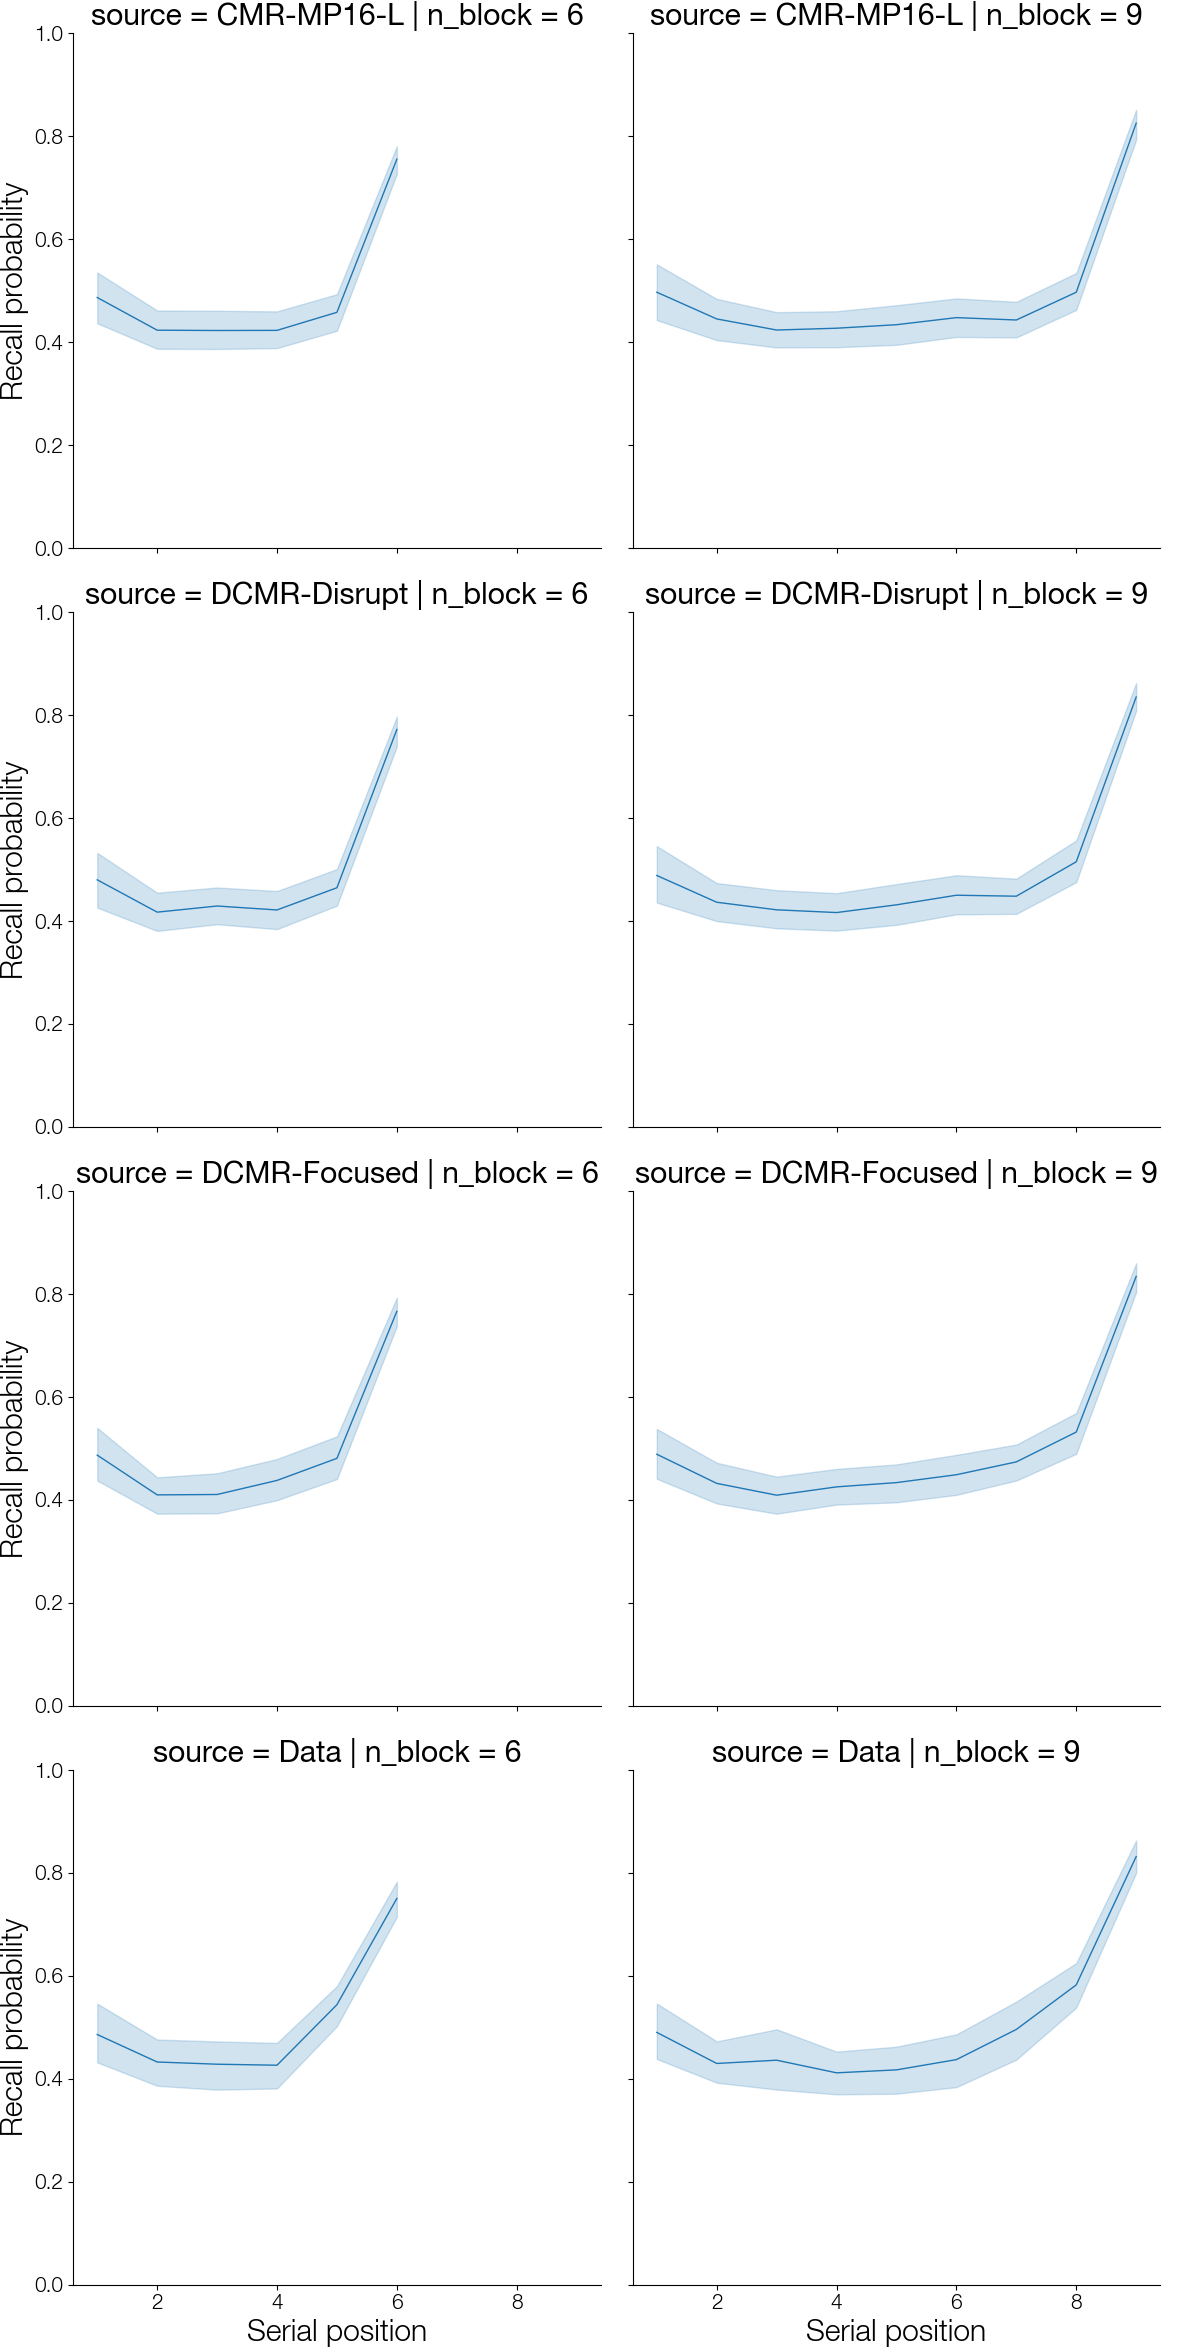

In [14]:
fr.plot_spc(spc, input_key='block', row='source', col='n_block', height=6).add_legend()

## Clustering measures

In [15]:
lag_rank_within = data.groupby('source').apply(
    fr.lag_rank, test_key='category', test=lambda x, y: x == y
)

In [16]:
df = lag_rank_within.reset_index()
df["source"] = pd.Categorical(
    df["source"],
    categories=order,
    ordered=True,
)

LINO NOT subset; don't know how to subset; dropped


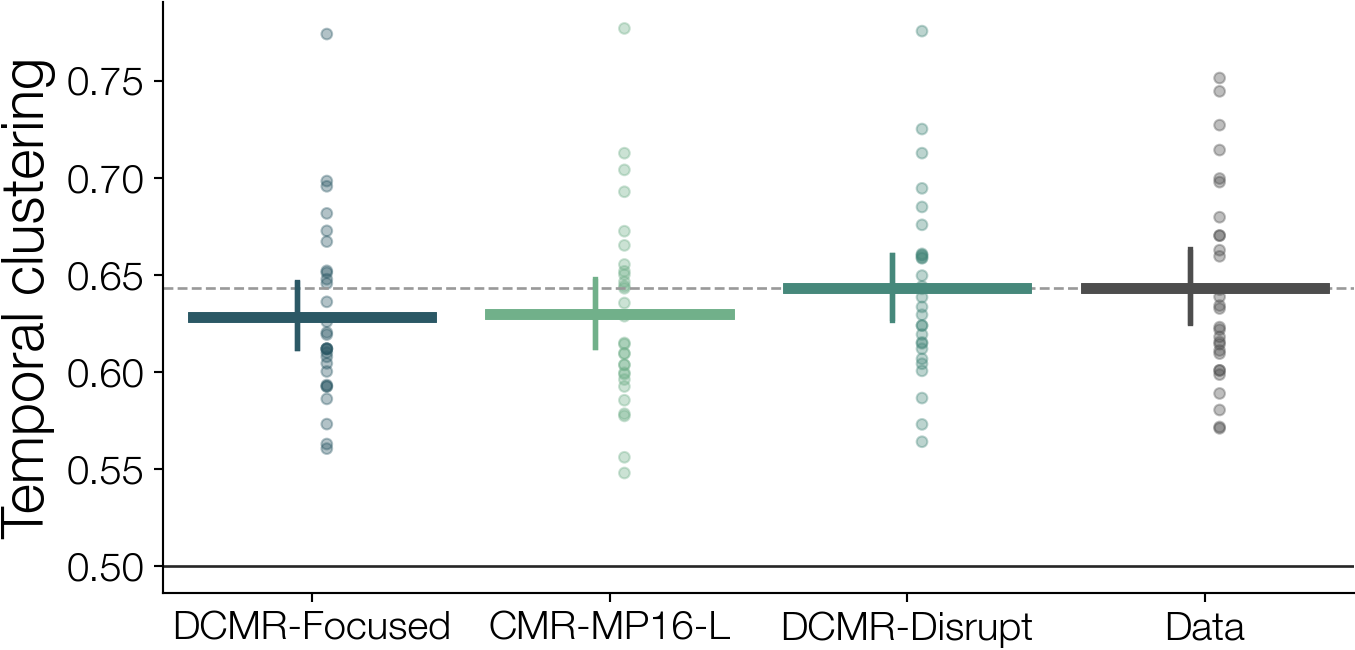

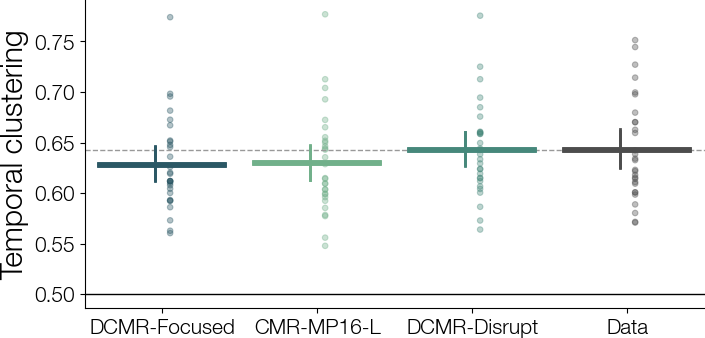

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
p = (
    so.Plot(df, x="source", y="rank", color="source")
    .add(so.Dash(linewidth=4), so.Agg(), legend=False)
    .add(so.Dots(alpha=0.2), so.Shift(x=0.05), legend=False)
    .add(so.Range(linewidth=2), so.Est(), so.Shift(x=-0.05), legend=False)
    .scale(color=curve)
    .label(y="Temporal clustering", x=None)
    .theme(plt.rcParams)
    .on(ax)
)
m = lag_rank_within.loc['Data', 'rank'].mean()
ax.axhline(m, color=(.6, .6, .6), linestyle="--")
ax.axhline(0.5, color="k", linestyle="-")
p.save(fig_dir / 'comp_line_lag_rank.pdf')

In [18]:
cat_crp = data.groupby('source').apply(
    fr.category_crp, category_key='category'
)

In [19]:
df = cat_crp.reset_index()
df["source"] = pd.Categorical(
    df["source"],
    categories=order,
    ordered=True,
)

LINO NOT subset; don't know how to subset; dropped


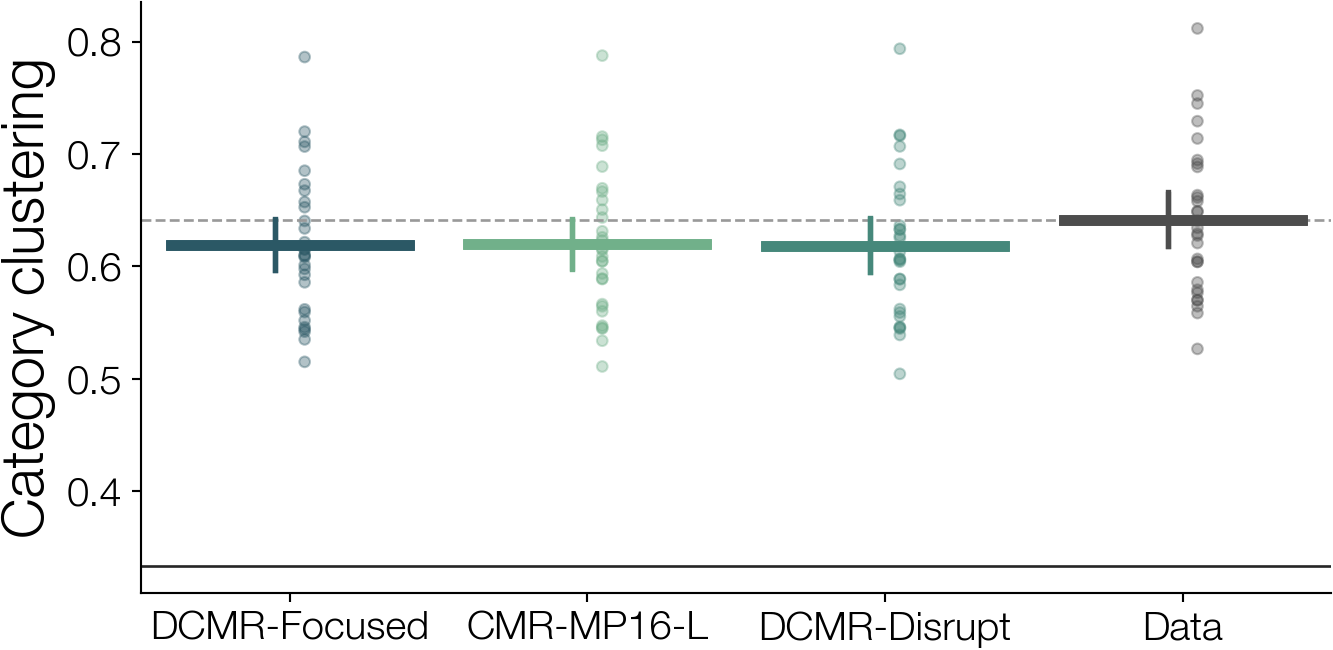

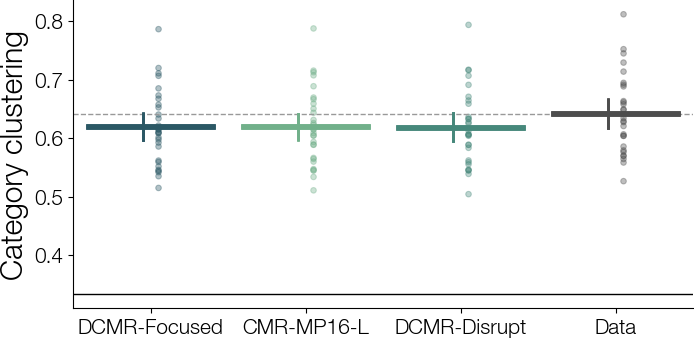

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
p = (
    so.Plot(df, x="source", y="prob", color="source")
    .add(so.Dash(linewidth=4), so.Agg(), legend=False)
    .add(so.Dots(alpha=0.2), so.Shift(x=0.05), legend=False)
    .add(so.Range(linewidth=2), so.Est(), so.Shift(x=-0.05), legend=False)
    .scale(color=curve)
    .label(y="Category clustering", x=None)
    .theme(plt.rcParams)
    .on(ax)
)
m = cat_crp.loc['Data', 'prob'].mean()
ax.axhline(m, color=(.6, .6, .6), linestyle="--")
ax.axhline(1/3, color="k", linestyle="-")
p.save(fig_dir / 'comp_line_cat_crp.pdf')

In [21]:
use_rank = data.groupby('source').apply(
    fr.distance_rank, 'item_index', 1 - rsm, test_key='category',
    test=lambda x, y: x == y
)

In [22]:
df = use_rank.reset_index()
df["source"] = pd.Categorical(
    df["source"],
    categories=order,
    ordered=True,
)

LINO NOT subset; don't know how to subset; dropped


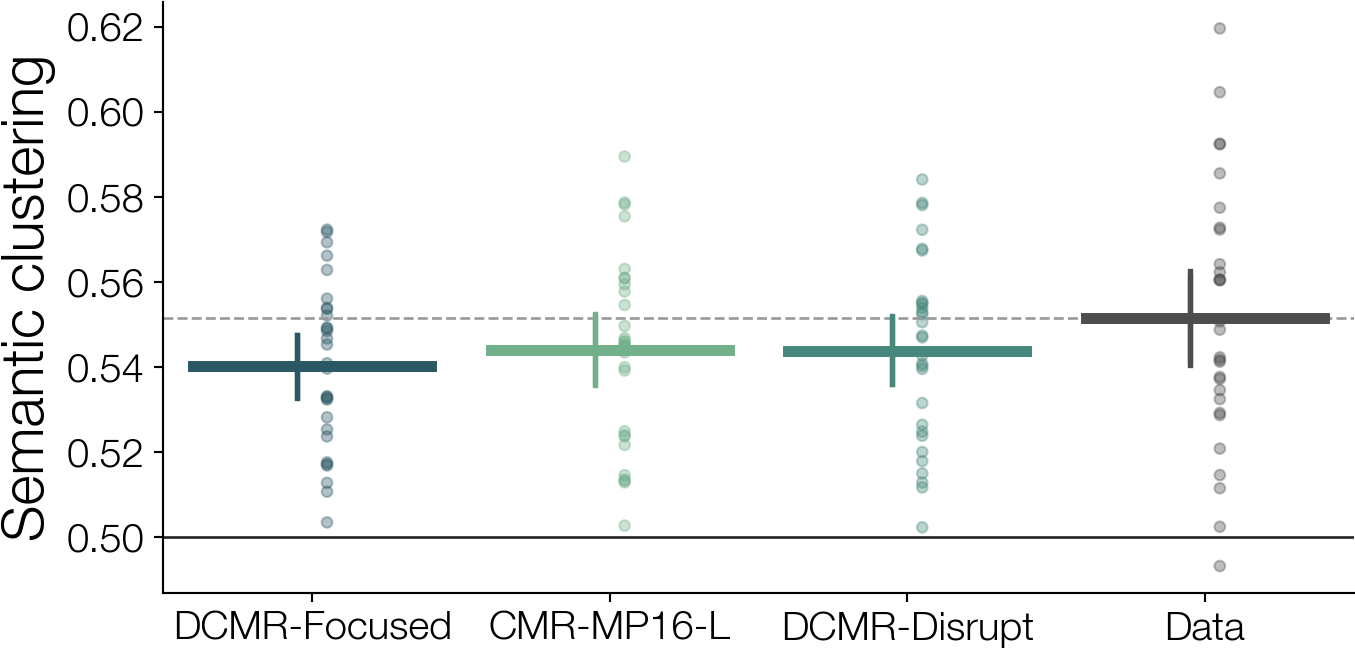

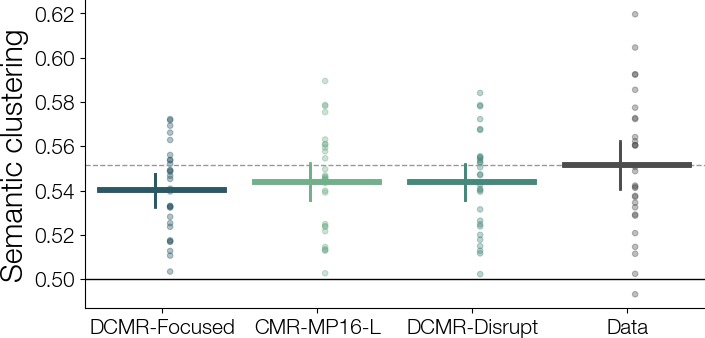

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
p = (
    so.Plot(df, x="source", y="rank", color="source")
    .add(so.Dash(linewidth=4), so.Agg(), legend=False)
    .add(so.Dots(alpha=0.2), so.Shift(x=0.05), legend=False)
    .add(so.Range(linewidth=2), so.Est(), so.Shift(x=-0.05), legend=False)
    .scale(color=curve)
    .label(y="Semantic clustering", x=None)
    .theme(plt.rcParams)
    .on(ax)
)
m = use_rank.loc['Data', 'rank'].mean()
ax.axhline(m, color=(.6, .6, .6), linestyle="--")
ax.axhline(1/2, color="k", linestyle="-")
p.save(fig_dir / 'comp_line_use_rank.pdf')

In [24]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.13.6
IPython version      : 9.9.0

cymr      : 0.14.3
dcmr      : 1.0.0a0
matplotlib: 3.10.8
numpy     : 2.4.1
pandas    : 3.0.0
pingouin  : 0.5.5
psifr     : 0.10.1
seaborn   : 0.13.2

